## Optimize hyperparameters with scikit-optimize

In [1]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

import netCDF4
from netCDF4 import Dataset

YEAR = 8766 # One year is 8766 hours
MONTH = 730.5 # One month is 730.5 hours
DATETIME_FMT = "%Y-%m-%d %H:%M"

In [2]:
import pandas as pd

# The table contains first flowering dates of 329 taxa over 33 years
# numbers are the day of year
df = pd.read_csv('./data/V_KEZD_Excel_SORTED_cut.csv', skiprows=1)
df.head(5)

,E.sz.,1968,1969,1970,1971,1972,1973,1974,1975,1976,...,1996,1997,1998,1999,2000,MEAN,STD,1st yr.,Last yr.,Nr.of yrs
0,3,46,61.0,66.0,39.0,41.0,31.0,25.0,5.0,37.0,...,63.0,37.0,20.0,57.0,39.0,36.303030,15.899473,NaN,NaN,33.0
1,3,46,62.0,68.0,42.0,46.0,39.0,37.0,19.0,51.0,...,59.0,37.0,17.0,57.0,32.0,37.727273,16.273892,NaN,NaN,33.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,37.0,...,60.0,30.0,22.0,57.0,37.0,41.913043,14.999758,NaN,NaN,22.5
3,3,49,68.0,72.0,44.0,48.0,42.0,37.0,17.0,57.0,...,66.0,37.0,20.0,57.0,40.0,42.424242,17.968977,NaN,NaN,33.0
4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,...,75.0,47.0,46.0,58.0,45.0,46.458333,13.356584,NaN,NaN,23.5


In [3]:
"""
Helper functions for date & time handling
"""
from datetime import datetime
from datetime import timezone

def datetimeToHour(dt):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_dt = datetime.strptime(dt, DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    return int((ts_dt-ts_null)//3600-692496)
datetimeToHour = np.vectorize(datetimeToHour)

def hourToTimestamp(h):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_date = int(ts_null) + 692496*3600 + 3600*h
    return ts_date
hourToTimestamp = np.vectorize(hourToTimestamp)

def hourToUTC(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts)
hourToUTC = np.vectorize(hourToUTC)

def hourToUTCFormatted(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts).strftime(DATETIME_FMT)
hourToUTCFormatted = np.vectorize(hourToUTCFormatted)

def getYearBeforeDateTime(dt):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-YEAR
    if hr_start < 0:
       raise ValueError("hr_start < 0")
    return hr_start, hr_end

def getMonthsBeforeDateTime(dt, nmonths):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-int(nmonths*MONTH)
    if hr_start < 0:
       raise ValueError("hr_start < 0")
    return hr_start, hr_end
  
def getYearBeforeTimestamp(ts):
    pass
  
import ephem     # provides scientific-grade astronomical computations
"""
IMPORTANT:
PyEphem dates are encoded as the “Dublin Julian Day”, which is the number of
days (including any fraction) that have passed since the last day of 1899, at noon. 
"""
def getsoltime(dt, long):
    gamma = 2. * np.pi / 365. * (dt.timetuple().tm_yday - 1 + float(dt.hour - 12) / 24)
    eqtime = 229.18 * (0.000075 + 0.001868 * np.cos(gamma) - 0.032077 * np.sin(gamma) \
             - 0.014615 * np.cos(2 * gamma) - 0.040849 * np.sin(2 * gamma))
    decl = 0.006918 - 0.399912 * np.cos(gamma) + 0.070257 * np.sin(gamma) \
           - 0.006758 * np.cos(2 * gamma) + 0.000907 * np.sin(2 * gamma) \
           - 0.002697 * np.cos(3 * gamma) + 0.00148 * np.sin(3 * gamma)
    time_offset = eqtime + 4 * long
    tst = dt.hour * 60 + dt.minute + dt.second / 60 + time_offset
    solar_time = datetime.combine(dt.date(), time(0)) + timedelta(minutes=tst)
    return solar_time
  
def getsunrise_sunset(date, lat=47.5, lon=19.0):
    iss = ephem.Observer()
    iss.date = date
    iss.lat = str(lat)                     # IMPORTANT TO CONVERT INTO STRING!!!
    iss.lon = str(lon)
    iss.elevation = 130                   # elevation of Albertfalva (in units of m)
    sun = ephem.Sun()
    r1 = iss.next_rising(sun)
    s1 = iss.next_setting(sun)
    return r1,s1

def tm(hour):
    # Calculate time at dawn for a given hour
    date = ephem.Date(str(hourToUTCFormatted(hour)))
    rs1, st1 = getsunrise_sunset(date)
    formatted = datetime.strftime(rs1.datetime(), DATETIME_FMT)
    return datetimeToHour(formatted)
tm = np.vectorize(tm)

"""
Some more helper funcs to get the data based on the csv file
"""
def utcFromYearAndDay(yr, day):
    if type(yr) == int:
        yr = str(yr)
    hours = datetimeToHour(
      datetime.strftime(datetime.strptime(yr, "%Y"),
                       DATETIME_FMT)
    )
    hours = hours + day*24
    return hourToUTCFormatted(hours)

def tempDataForYearAndDay(yr, day, nmonths, transformTime=False):
    """
     Return t, and T for nmonths backward from a given date
    """
    hrs, hre = getMonthsBeforeDateTime(utcFromYearAndDay(yr, day), nmonths=18)
    slc = slice(hrs, int(hre), 1)
    ts = hours[slc]
    Ts = temps[slc]
    if transformTime == True:
        ts = ts-np.max(ts)
    return ts, Ts

In [4]:
ds = Dataset("./data/ERA5-hourly-merged.nc")
stl2 = np.array(ds.variables['stl2'])
long = np.array(ds.variables['longitude'])
lat = np.array(ds.variables['latitude'])
print("lat = {} long = {}".format(lat[0], long[0]))

# the relevant data is stl2[0][0]
temps = np.array([x[0][0] for x in stl2]).astype(float)
hours = np.array(ds.variables['time']) 
# Calculate time at dawn for each element in 'hours'
# tms = tm(hours) NOT needed now

lat = 47.5 long = 19.0


In [5]:
def Tm(hour):
    # Calculate Tmax since the last resetting for a given hour
    delta = 0
    if hour%24 >= 16:
        delta = hour%24 - 16
    else:
        delta = 8 + hour%24 
    slc = slice(hour-delta, hour)
    if delta == 0:
        return temps[hour]
    else:
        try:
            return np.max(temps[slc])
        except:
            return temps[hour]
Tm = np.vectorize(Tm)

In [6]:
"""
Class for the LSC model that can be evaluated with data input
"""
class LSCModel:
    def __init__(self, dV, snu, S1, TL, dL, Tc1, Tc2, pc1, pc2, TS):
        def dLdt(L, T):
            # L is the current value of L, 
            # T is the current temperature
            T = T - 273.15
            if T < TL:
                return 1-dL*L
            else:
                return -dL*L
        self.dLdt = dLdt

        def S(Tm):
            # Tm is the maximum temperature since the last resetting,
            # which was chosen to occur each day at 4pm.
            Tm = Tm - 273.15
            if Tm < TS:
                return 1.0
            else: 
                return S1
        self.S = np.vectorize(S)

        def C(T):
            # T is the current temperature
            T = T - 273.15
            if T <= Tc1:
                return pc1
            elif T < Tc2:
                return pc1 - pc2*((T-Tc1)/(Tc2-Tc1))
            else:
                return pc2
        self.C = np.vectorize(C)
    
    def evaluate(self, data):
        ts, Ts = data
        if not len(ts) == len(Ts):
            raise ValueError("ts and Ts mus have the same length")

        Ls = []
        Ss = []
        Cs = []
        for idx in range(len(ts)):
            L = [0]
            for k in range(0, len(Ts[idx])-1):
                L.append(L[-1] + (1/24.0)*self.dLdt(L[-1], Ts[idx][k]))
            Ls.append(L)
            Ss.append( self.S(Tm(ts[idx])) )
            Cs.append( self.C(Ts[idx]) )
        LSCs = [Ls[idx]*Ss[idx]*Cs[idx] for idx in range(len(ts))]
        sigma = np.std([LSCs[idx][-1] for idx in range(len(ts))])
        mean = np.average([LSCs[idx][-1] for idx in range(len(ts))])
        return sigma/mean

In [17]:
# Select data
rowindex = 0

# Hack
flowering_dates = list(
    zip(
      list(df.iterrows())[rowindex][1].keys(),
      list(df.iterrows())[rowindex][1].values
    )
)

# Filter out columns with years
flowering_dates = [fd for fd in flowering_dates if fd[0].isdigit()]

# Get temperature data
ts = []
Ts = []
yearsndays = []
for fd in flowering_dates:
    try:
        t, T  = tempDataForYearAndDay(*fd, 12, transformTime=True)
        ts.append(t)
        Ts.append(T)
        yearsndays.append(fd)
    except:
        print("Operation failed for year {}".format(fd[0]))
print(yearsndays)

Operation failed for year 1968
Operation failed for year 1969
Operation failed for year 1970
Operation failed for year 1971
Operation failed for year 1972
Operation failed for year 1973
Operation failed for year 1974
Operation failed for year 1975
Operation failed for year 1976
Operation failed for year 1977
Operation failed for year 1978
Operation failed for year 1979
Operation failed for year 1980
[('1981', 32.0), ('1982', 51.0), ('1983', 19.0), ('1984', 35.0), ('1985', 64.0), ('1986', 65.0), ('1987', 48.0), ('1988', 21.0), ('1989', 21.0), ('1990', 24.0), ('1991', 12.0), ('1992', 31.0), ('1993', 23.0), ('1994', 13.0), ('1995', 29.0), ('1996', 63.0), ('1997', 37.0), ('1998', 20.0), ('1999', 57.0), ('2000', 39.0)]


In [18]:
# Just a test
default_params = dict(dV=18., snu=4.4*18., S1=0.75, TL=17.0, dL=0.009, Tc1=8.0, Tc2=15.4, pc1=0.0315, pc2=0.03, TS=15)
model = LSCModel(**default_params)
model.evaluate((ts,Ts))

0.05019455009936658

In [10]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

"""
We define a parameter space:
parameter type, bounds, distribution and name
"""
space = [
  Real(12.0, 25.0, 'uniform', name='dV'),
  Real(20.0, 80.0, 'uniform', name='snu'),
  Real(0.2, 2.5, 'uniform', name='S1'),
  Real(15.0, 35.0, 'uniform', name='TL'),
  Real(1e-3, 1.0, 'log_uniform', name='dL'),
  Real(4.0, 20.0, 'uniform', name='Tc1'),
  Real(10.0, 25.0, 'uniform', name='Tc2'),
  Real(0.005, 0.1, 'uniform', name='pc1'),
  Real(0.005, 0.1, 'uniform', name='pc2'),
  Real(10.0, 25.0, 'uniform', name='TS')
]

@use_named_args(space)
def objective(**params):
    model = LSCModel(**params)
    return model.evaluate((ts, Ts))

/Users/nagydaniel/anaconda3/envs/pt11/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
"""
Gaussian process optimization
"""
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.8588
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.7890
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7617
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.7949
Function value obtained: 0.0451
Current minimum: 0.0000
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.7702
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 6 started. Evaluating

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 4.0934
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.2182
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.3239
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.3839
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.7405
Function value obtained: 0.0207
Current minimum: 0.0000
Iteration No: 46 started. Sea

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 3.0114
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 3.0559
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 3.3253
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.0029
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 2.9441
Function value obtained: 0.0006
Current minimum: 0.0000
Iteration No: 86 started. Sea

In [12]:
res_gp.x

[19.706980036925238,
 70.65594491486105,
 2.173274920532341,
 31.94503477568251,
 0.07424908231815013,
 10.150107316683199,
 14.463019098167084,
 0.010387732845157104,
 0.03090234798511076,
 17.16497675982025]

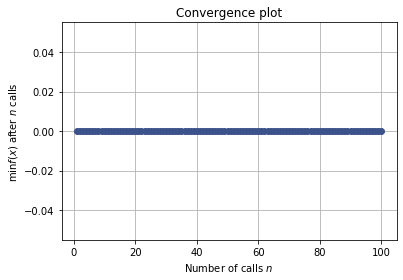

In [13]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

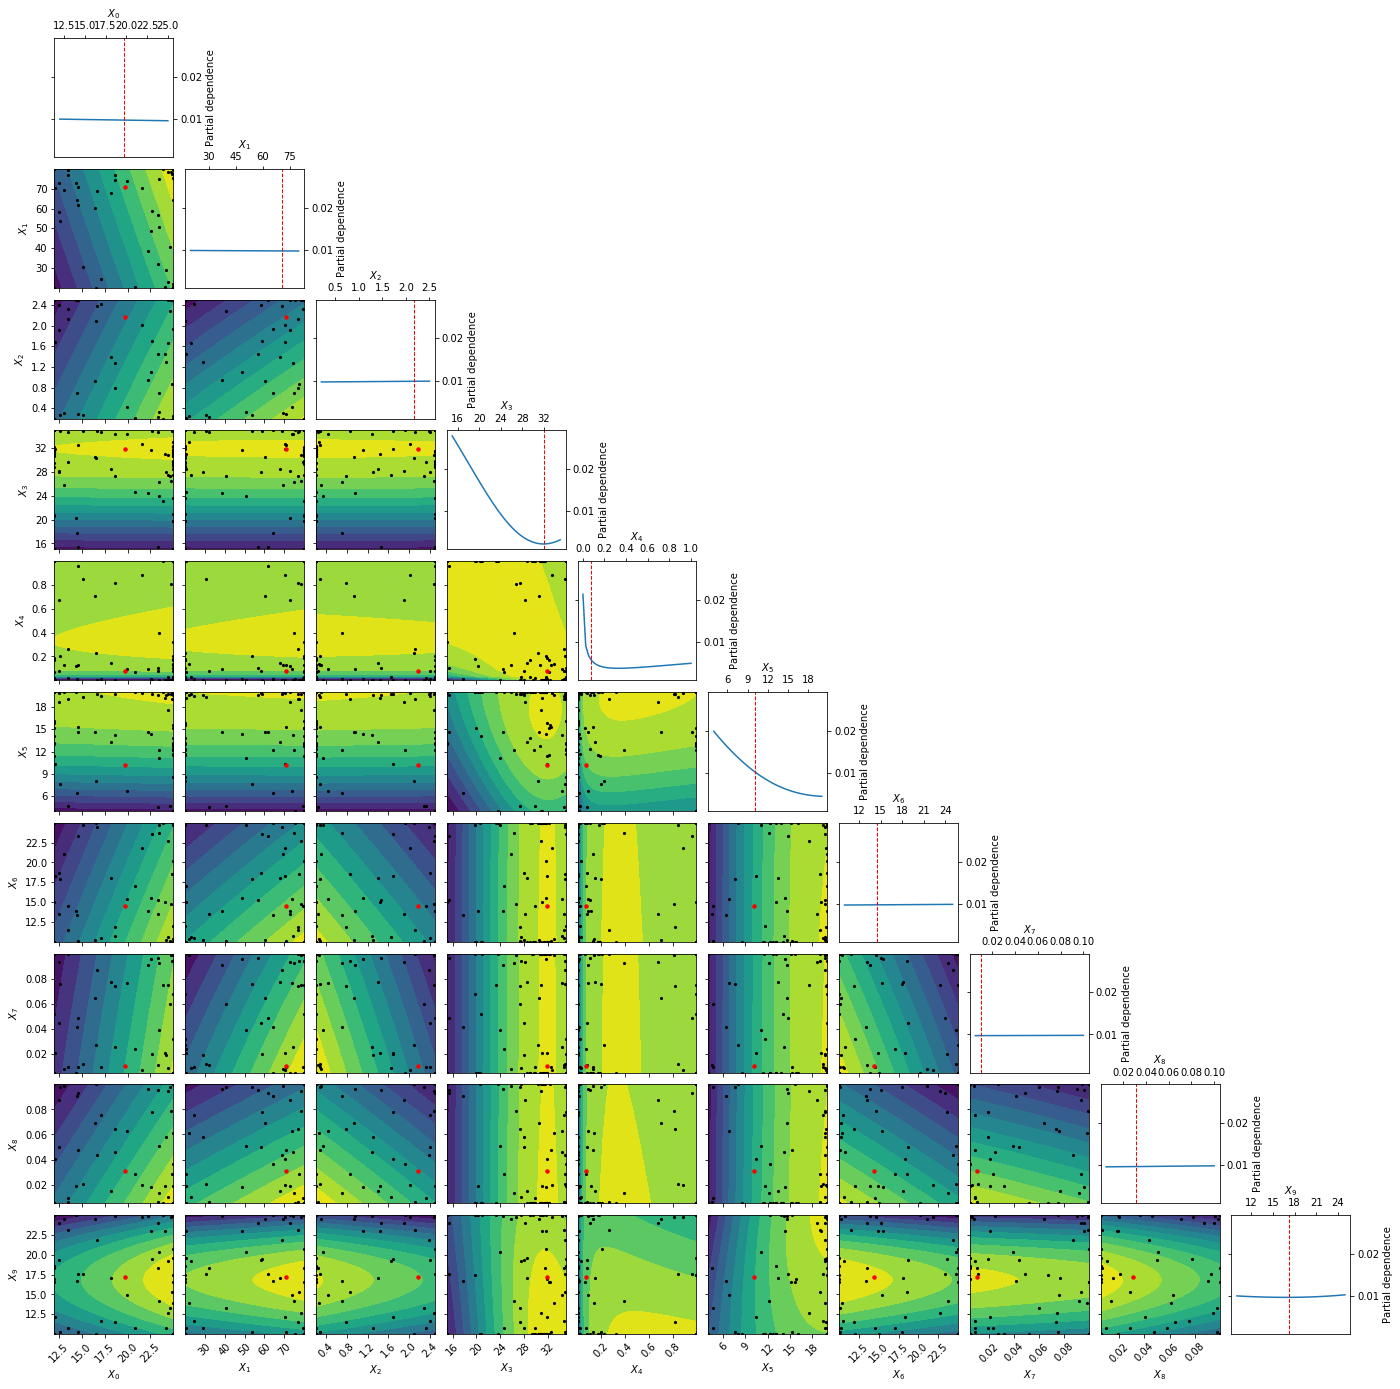

In [14]:
from skopt.plots import plot_objective
plot_objective(res_gp)
plt.savefig("LSC_skopt_objective.png", dpi=196)

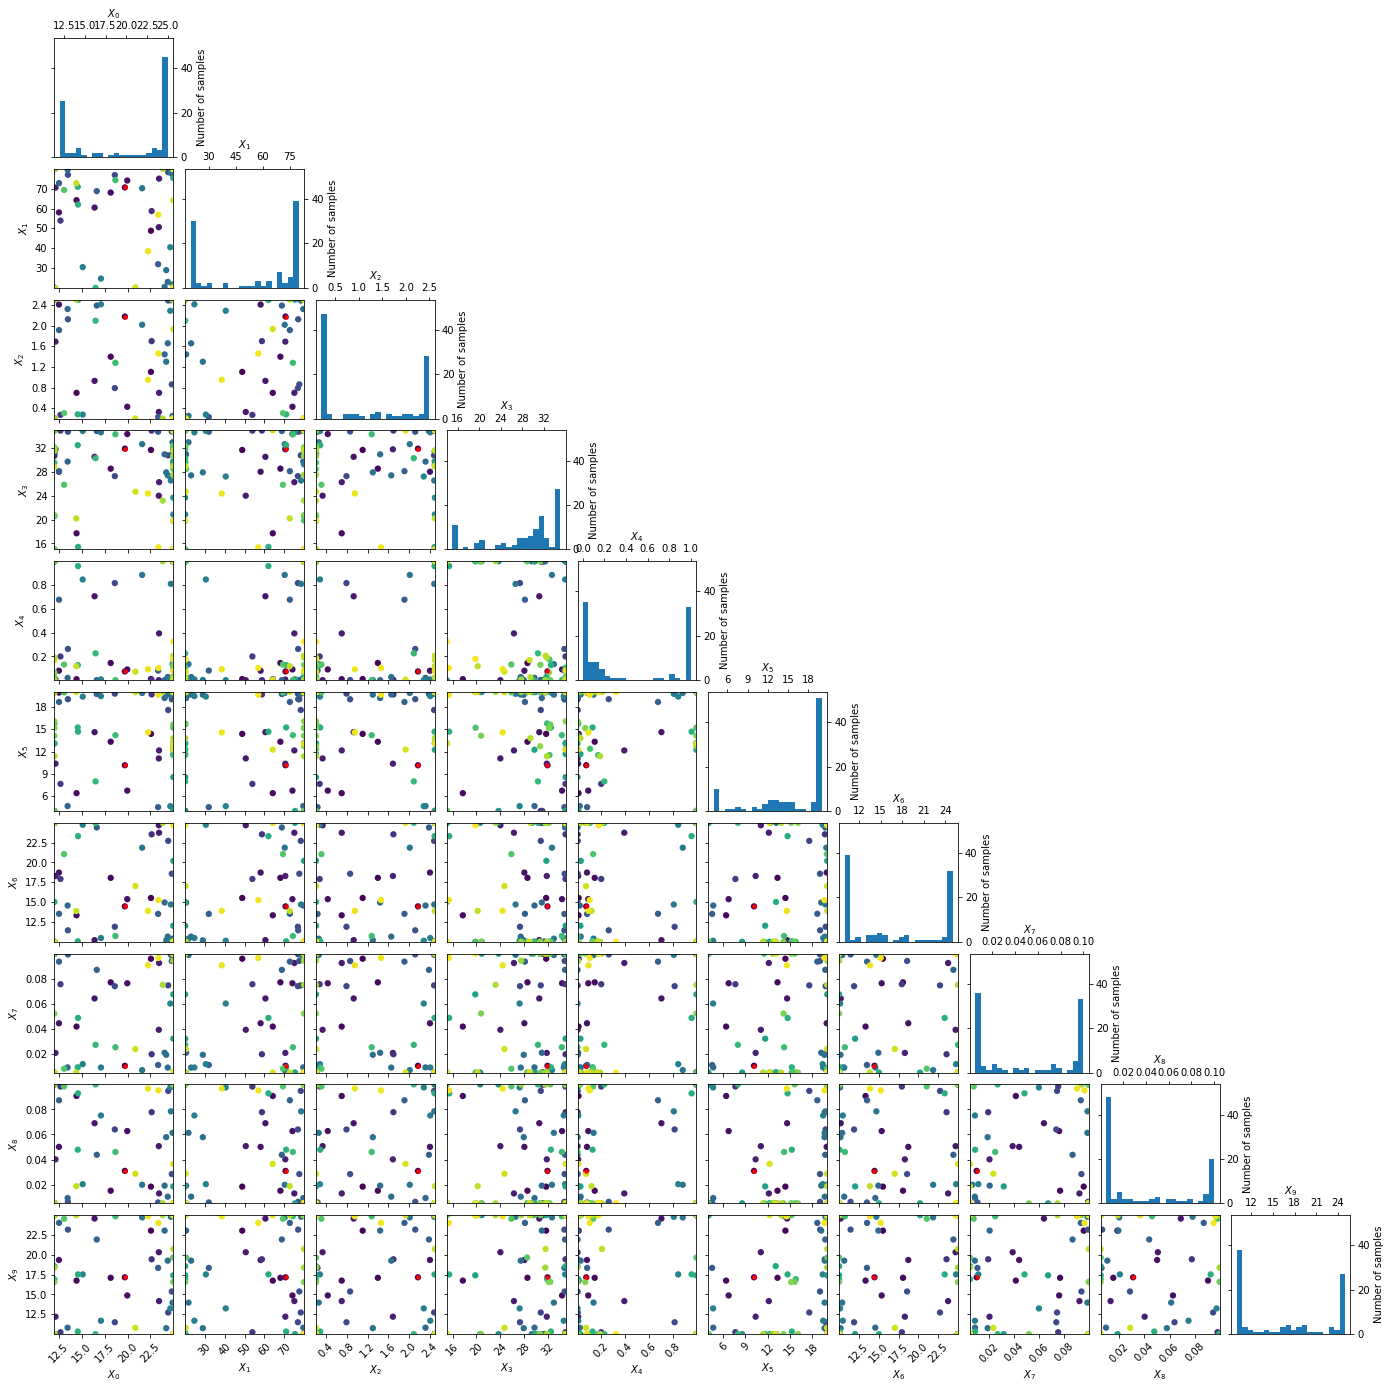

In [15]:
from skopt.plots import plot_evaluations
fig = plot_evaluations(res_gp)
plt.savefig("LSC_skopt_evals.png", dpi=196)